# Bank Marketing Campaign Analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix, 
    roc_curve, auc, precision_recall_curve,
    accuracy_score, balanced_accuracy_score,
    precision_score, recall_score, f1_score, 
    matthews_corrcoef, roc_auc_score
)
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

print("="*60)
print(" BANK MARKETING CAMPAIGN - ML ANALYSIS")
print(" Logistic Regression vs Random Forest")
print("="*60)

 BANK MARKETING CAMPAIGN - ML ANALYSIS
 Logistic Regression vs Random Forest


In [3]:
# Cell 2: Define Color Scheme
"""
Soft pastel color scheme for visualizations
"""

# Color scheme
color_class1 = np.array([0.4, 0.6, 0.85])  # Soft blue
color_class2 = np.array([0.95, 0.7, 0.5])  # Soft orange
color_class3 = np.array([0.6, 0.8, 0.6])   # Soft green

# For 2-class problem
color_no = color_class1   # Blue for "No"
color_yes = color_class2  # Orange for "Yes"

# Model colors
color_lr = np.array([0.5, 0.65, 0.85])   # Soft blue for LR
color_rf = np.array([0.9, 0.65, 0.5])    # Soft orange for RF

# Additional colors
color_train = np.array([0.65, 0.8, 0.7])  # Soft green
color_test = np.array([0.85, 0.7, 0.65])  # Soft pink/orange

print("✓ Color scheme defined")

✓ Color scheme defined


In [4]:
# Cell 3: Load Data
"""
Load the Bank Marketing dataset
Dataset: UCI Bank Marketing (bank-additional-full.csv)
"""

print("\nLoading dataset...")

# Load data
data = pd.read_csv('bank-additional-full.csv', delimiter=';')

print(f"✓ Loaded: {data.shape[0]} samples, {data.shape[1]} variables")
print(f"\nDataset shape: {data.shape}")
print(f"\nFirst few rows:")
print(data.head())
print(f"\nColumn names:")
print(data.columns.tolist())
print(f"\nData types:")
print(data.dtypes)
print(f"\nMissing values:")
print(data.isnull().sum())


Loading dataset...
✓ Loaded: 41188 samples, 21 variables

Dataset shape: (41188, 21)

First few rows:
   age        job  marital    education  default housing loan    contact month day_of_week  duration  campaign  pdays  previous     poutcome  emp.var.rate  cons.price.idx  cons.conf.idx  euribor3m  nr.employed   y
0   56  housemaid  married     basic.4y       no      no   no  telephone   may         mon       261         1    999         0  nonexistent           1.1          93.994          -36.4      4.857       5191.0  no
1   57   services  married  high.school  unknown      no   no  telephone   may         mon       149         1    999         0  nonexistent           1.1          93.994          -36.4      4.857       5191.0  no
2   37   services  married  high.school       no     yes   no  telephone   may         mon       226         1    999         0  nonexistent           1.1          93.994          -36.4      4.857       5191.0  no
3   40     admin.  married     basic.6y  

In [5]:
# Cell 4: Preprocessing - Create Labels and Feature Sets
"""
Preprocessing:
1. Convert target variable to binary (0/1)
2. Separate numeric and categorical features
3. One-hot encode categorical variables
4. Standardize numeric features
"""

print("\n" + "="*60)
print("PREPROCESSING")
print("="*60)

# Create binary labels
labels = (data['y'] == 'yes').astype(int)

# Numeric features (DURATION REMOVED to prevent data leakage)
numeric_features = [
    'age', 'campaign', 'pdays', 'previous',
    'emp.var.rate', 'cons.price.idx', 'cons.conf.idx',
    'euribor3m', 'nr.employed'
]

X_numeric = data[numeric_features].values

# Categorical features
categorical_features = [
    'job', 'marital', 'education', 'default', 'housing',
    'loan', 'contact', 'month', 'day_of_week', 'poutcome'
]

# One-hot encode categorical features (drop first to avoid multicollinearity)
X_categorical = pd.get_dummies(data[categorical_features], drop_first=True)
cat_names = X_categorical.columns.tolist()

# Combine numeric and categorical
X_all = np.concatenate([X_numeric, X_categorical.values], axis=1)
all_feature_names = numeric_features + cat_names

# Standardize numeric features only
scaler = StandardScaler()
X_standardized = X_all.copy()
X_standardized[:, :len(numeric_features)] = scaler.fit_transform(X_all[:, :len(numeric_features)])

print(f"✓ Numeric features: {len(numeric_features)}")
print(f"✓ Categorical dummies: {len(cat_names)}")
print(f"✓ Total features: {X_standardized.shape[1]}")
print(f"✓ Target distribution:")
print(f"   Yes: {labels.sum()} ({100*labels.mean():.1f}%)")
print(f"   No: {(1-labels).sum()} ({100*(1-labels.mean()):.1f}%)")
print(f"✓ Class imbalance ratio: {(1-labels).sum()/labels.sum():.1f}:1")


PREPROCESSING
✓ Numeric features: 9
✓ Categorical dummies: 43
✓ Total features: 52
✓ Target distribution:
   Yes: 4640 (11.3%)
   No: 36548 (88.7%)
✓ Class imbalance ratio: 7.9:1



EXPLORATORY DATA ANALYSIS

Figure 1: Class Distribution (Pie Chart)...


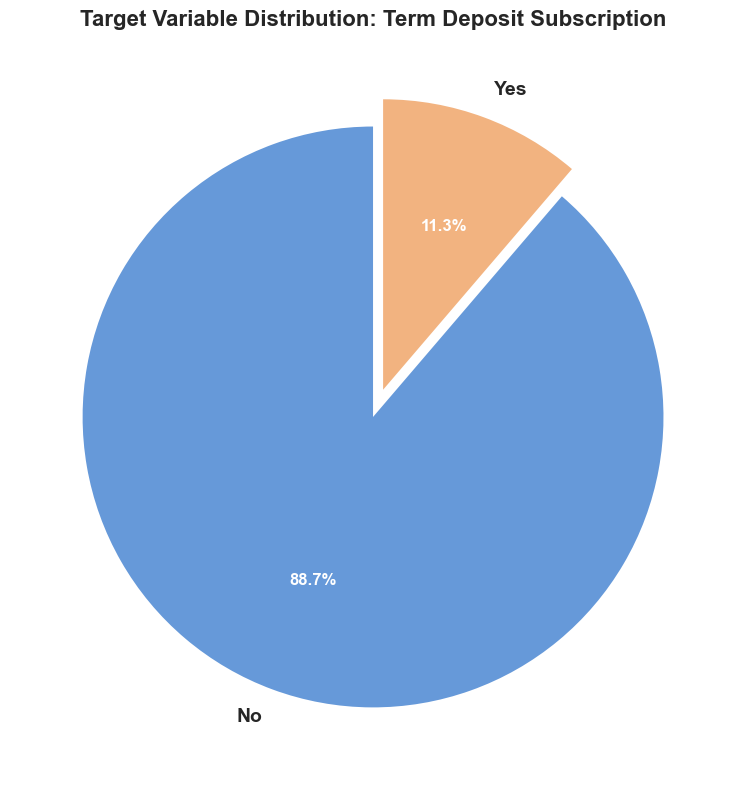

In [7]:
# Cell 5: Exploratory Data Analysis - Class Distribution
"""
Figure 1: Class Distribution (Pie Chart)
"""

print("\n" + "="*60)
print("EXPLORATORY DATA ANALYSIS")
print("="*60)

print("\nFigure 1: Class Distribution (Pie Chart)...")

fig, ax = plt.subplots(figsize=(10, 8))

class_counts = [(1-labels).sum(), labels.sum()]
labels_pie = ['No', 'Yes']
colors = [color_no, color_yes]
explode = (0, 0.1)  # Explode the "Yes" slice

wedges, texts, autotexts = ax.pie(
    class_counts, 
    labels=labels_pie,
    colors=colors,
    autopct='%1.1f%%',
    startangle=90,
    explode=explode,
    textprops={'fontsize': 14, 'weight': 'bold'}
)

# Enhance text
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontsize(12)

ax.set_title('Target Variable Distribution: Term Deposit Subscription', 
             fontsize=16, weight='bold', pad=20)

plt.tight_layout()
plt.show()


Figure 2: Age Demographics...


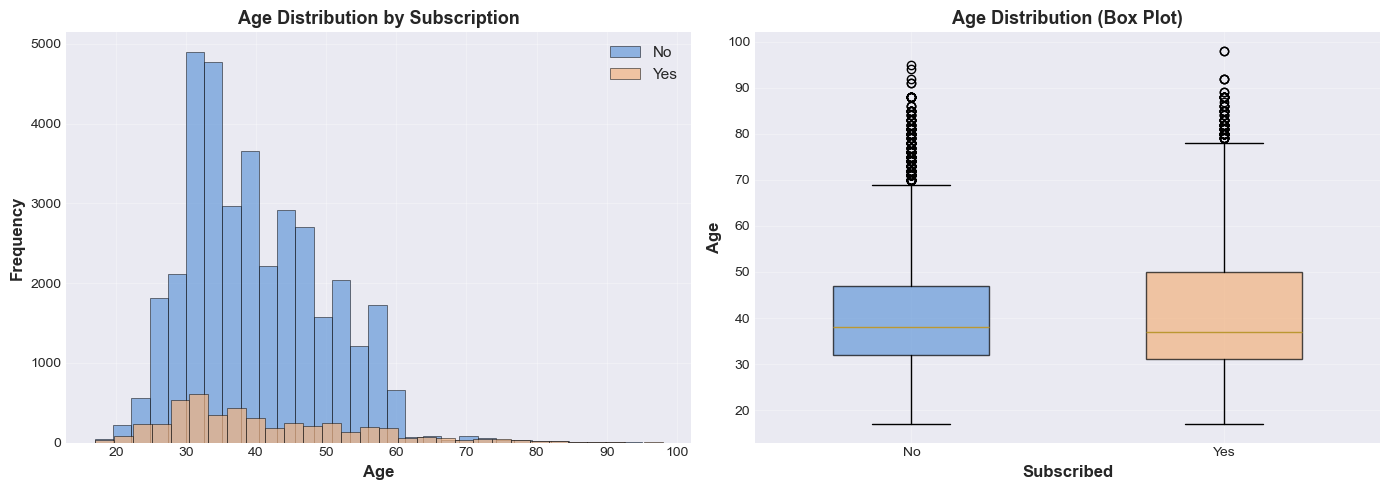

In [8]:
# Cell 6: EDA - Age Analysis
"""
Figure 2: Age Demographics Analysis
"""

print("\nFigure 2: Age Demographics...")

age_no = data.loc[labels == 0, 'age'].values
age_yes = data.loc[labels == 1, 'age'].values

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
axes[0].hist(age_no, bins=30, alpha=0.7, color=color_no, 
             edgecolor='black', linewidth=0.5, label='No')
axes[0].hist(age_yes, bins=30, alpha=0.7, color=color_yes, 
             edgecolor='black', linewidth=0.5, label='Yes')
axes[0].set_xlabel('Age', fontsize=12, weight='bold')
axes[0].set_ylabel('Frequency', fontsize=12, weight='bold')
axes[0].set_title('Age Distribution by Subscription', fontsize=13, weight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# Box plot
bp = axes[1].boxplot(
    [age_no, age_yes],
    labels=['No', 'Yes'],
    patch_artist=True,
    widths=0.5,
    showfliers=True
)

# Color the boxes
bp['boxes'][0].set_facecolor(color_no)
bp['boxes'][0].set_alpha(0.7)
bp['boxes'][1].set_facecolor(color_yes)
bp['boxes'][1].set_alpha(0.7)

axes[1].set_ylabel('Age', fontsize=12, weight='bold')
axes[1].set_xlabel('Subscribed', fontsize=12, weight='bold')
axes[1].set_title('Age Distribution (Box Plot)', fontsize=13, weight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


Figure 3: Correlation Heatmap...


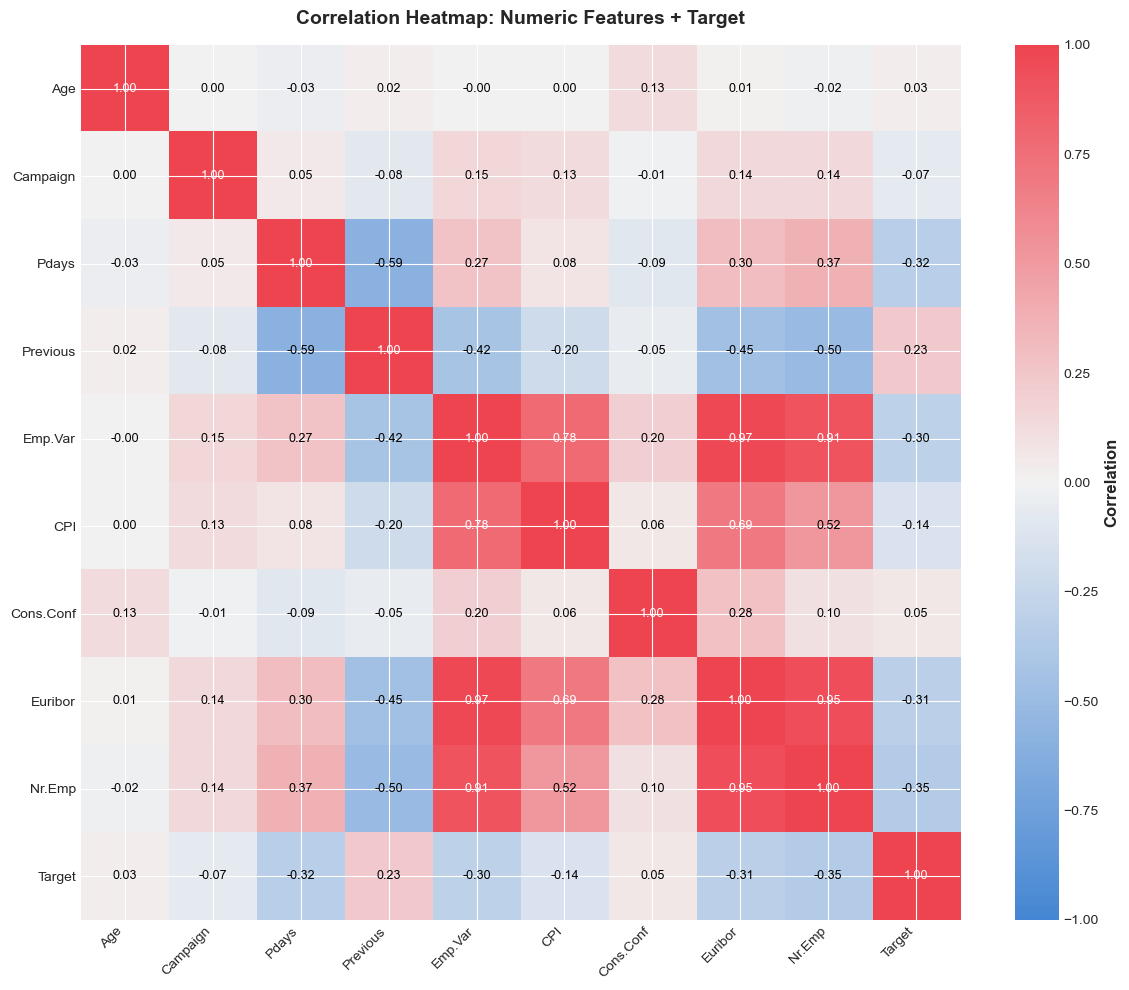

In [9]:
# Cell 7: EDA - Correlation Heatmap
"""
Figure 3: Correlation Heatmap
"""

print("\nFigure 3: Correlation Heatmap...")

# Create correlation matrix with target
X_with_target = np.column_stack([X_numeric, labels])
names_short = [
    'Age', 'Campaign', 'Pdays', 'Previous', 
    'Emp.Var', 'CPI', 'Cons.Conf', 'Euribor', 'Nr.Emp', 'Target'
]

corr_matrix = np.corrcoef(X_with_target.T)

# Create figure
fig, ax = plt.subplots(figsize=(12, 10))

# Create custom colormap (blue-white-red)
cmap = sns.diverging_palette(250, 10, s=80, l=55, n=256, as_cmap=True)

# Plot heatmap
im = ax.imshow(corr_matrix, cmap=cmap, aspect='auto', vmin=-1, vmax=1)

# Set ticks and labels
ax.set_xticks(np.arange(len(names_short)))
ax.set_yticks(np.arange(len(names_short)))
ax.set_xticklabels(names_short, rotation=45, ha='right')
ax.set_yticklabels(names_short)

# Add colorbar
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('Correlation', fontsize=12, weight='bold')

# Annotate cells with correlation values
for i in range(len(names_short)):
    for j in range(len(names_short)):
        val = corr_matrix[i, j]
        
        # Choose text color based on background
        if abs(val) < 0.4:
            text_color = 'black'
        elif val > 0.6 or val < -0.6:
            text_color = 'white'
        else:
            text_color = 'black'
        
        text = ax.text(j, i, f'{val:.2f}',
                      ha='center', va='center', 
                      color=text_color, fontsize=9)

ax.set_title('Correlation Heatmap: Numeric Features + Target', 
             fontsize=14, weight='bold', pad=15)

plt.tight_layout()
plt.show()


Figure 4: Campaign Features Analysis...


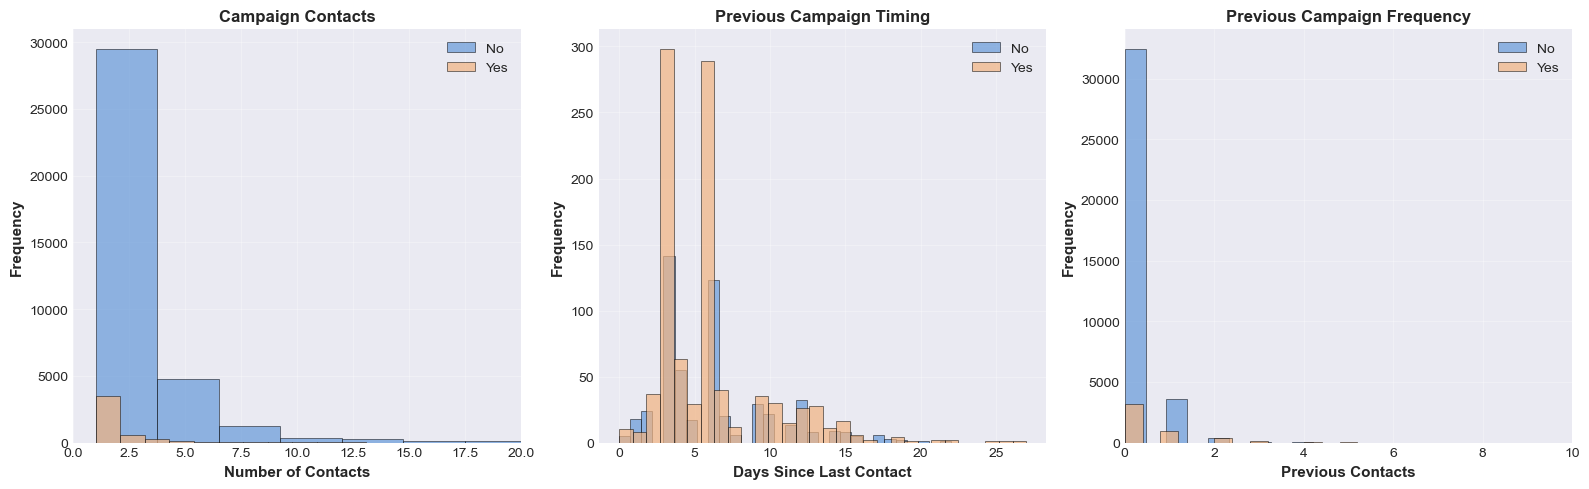

In [10]:
# Cell 8: EDA - Campaign Features
"""
Figure 4: Campaign Features Analysis
"""

print("\nFigure 4: Campaign Features Analysis...")

campaign_no = data.loc[labels == 0, 'campaign'].values
campaign_yes = data.loc[labels == 1, 'campaign'].values
pdays_no = data.loc[labels == 0, 'pdays'].values
pdays_yes = data.loc[labels == 1, 'pdays'].values
previous_no = data.loc[labels == 0, 'previous'].values
previous_yes = data.loc[labels == 1, 'previous'].values

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Campaign contacts
axes[0].hist(campaign_no, bins=20, alpha=0.7, color=color_no, 
             edgecolor='black', linewidth=0.5, label='No')
axes[0].hist(campaign_yes, bins=20, alpha=0.7, color=color_yes, 
             edgecolor='black', linewidth=0.5, label='Yes')
axes[0].set_xlabel('Number of Contacts', fontsize=11, weight='bold')
axes[0].set_ylabel('Frequency', fontsize=11, weight='bold')
axes[0].set_title('Campaign Contacts', fontsize=12, weight='bold')
axes[0].legend(fontsize=10)
axes[0].set_xlim([0, 20])
axes[0].grid(True, alpha=0.3)

# Days since last contact
pdays_no_filtered = pdays_no[pdays_no < 900]
pdays_yes_filtered = pdays_yes[pdays_yes < 900]

axes[1].hist(pdays_no_filtered, bins=30, alpha=0.7, color=color_no, 
             edgecolor='black', linewidth=0.5, label='No')
axes[1].hist(pdays_yes_filtered, bins=30, alpha=0.7, color=color_yes, 
             edgecolor='black', linewidth=0.5, label='Yes')
axes[1].set_xlabel('Days Since Last Contact', fontsize=11, weight='bold')
axes[1].set_ylabel('Frequency', fontsize=11, weight='bold')
axes[1].set_title('Previous Campaign Timing', fontsize=12, weight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

# Previous contacts
axes[2].hist(previous_no, bins=15, alpha=0.7, color=color_no, 
             edgecolor='black', linewidth=0.5, label='No')
axes[2].hist(previous_yes, bins=15, alpha=0.7, color=color_yes, 
             edgecolor='black', linewidth=0.5, label='Yes')
axes[2].set_xlabel('Previous Contacts', fontsize=11, weight='bold')
axes[2].set_ylabel('Frequency', fontsize=11, weight='bold')
axes[2].set_title('Previous Campaign Frequency', fontsize=12, weight='bold')
axes[2].legend(fontsize=10)
axes[2].set_xlim([0, 10])
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [11]:
# Cell 9: Train/Test Split
"""
Split data into training and testing sets (70/30 split, stratified)
"""

print("\n" + "="*60)
print("TRAIN/TEST SPLIT")
print("="*60)

X_train, X_test, y_train, y_test = train_test_split(
    X_standardized, labels, 
    test_size=0.30, 
    stratify=labels, 
    random_state=42
)

print(f"✓ Train: {len(y_train)} samples (Yes: {100*y_train.mean():.1f}%)")
print(f"✓ Test: {len(y_test)} samples (Yes: {100*y_test.mean():.1f}%)")


TRAIN/TEST SPLIT
✓ Train: 28831 samples (Yes: 11.3%)
✓ Test: 12357 samples (Yes: 11.3%)


In [12]:
# Cell 10: Logistic Regression - Hyperparameter Tuning
"""
Train Logistic Regression with Ridge regularization
Tune the regularization parameter C (inverse of lambda)
"""

print("\n" + "="*60)
print("LOGISTIC REGRESSION")
print("="*60)

print("\nTuning hyperparameters (C parameter via GridSearchCV)...")

import time

# Define parameter grid (C = 1/lambda in scikit-learn)
lambda_grid = np.logspace(-6, 1, 15)
C_grid = 1 / lambda_grid

param_grid = {'C': C_grid}

# Create GridSearchCV
lr_cv = GridSearchCV(
    LogisticRegression(penalty='l2', max_iter=1000, random_state=42, solver='lbfgs'),
    param_grid,
    cv=10,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=0
)

# Fit
start_time = time.time()
lr_cv.fit(X_train, y_train)
train_time_lr = time.time() - start_time

best_C = lr_cv.best_params_['C']
best_cv_auc = lr_cv.best_score_

print(f"✓ Best C: {best_C:.6f} (equivalent Lambda: {1/best_C:.6f})")
print(f"✓ Best CV AUC: {best_cv_auc:.4f}")

# Train final model with best parameters
print("\nTraining final model...")
model_lr = lr_cv.best_estimator_

print(f"✓ Training Time: {train_time_lr:.3f} seconds")


LOGISTIC REGRESSION

Tuning hyperparameters (C parameter via GridSearchCV)...
✓ Best C: 0.100000 (equivalent Lambda: 10.000000)
✓ Best CV AUC: 0.7869

Training final model...
✓ Training Time: 14.865 seconds


In [13]:
# Cell 11: Logistic Regression - Evaluation
"""
Evaluate Logistic Regression on test set
"""

# Predictions
y_train_pred_lr = model_lr.predict(X_train)
y_test_pred_lr = model_lr.predict(X_test)
y_train_prob_lr = model_lr.predict_proba(X_train)[:, 1]
y_test_prob_lr = model_lr.predict_proba(X_test)[:, 1]

# Calculate metrics
train_acc_lr = accuracy_score(y_train, y_train_pred_lr)
test_acc_lr = accuracy_score(y_test, y_test_pred_lr)

# Confusion matrix
cm_lr = confusion_matrix(y_test, y_test_pred_lr)
tn_lr, fp_lr, fn_lr, tp_lr = cm_lr.ravel()

# Metrics
prec_lr = precision_score(y_test, y_test_pred_lr)
rec_lr = recall_score(y_test, y_test_pred_lr)
f1_lr = f1_score(y_test, y_test_pred_lr)
bal_acc_lr = balanced_accuracy_score(y_test, y_test_pred_lr)
mcc_lr = matthews_corrcoef(y_test, y_test_pred_lr)
auc_lr = roc_auc_score(y_test, y_test_prob_lr)

print("\n" + "-"*60)
print("LOGISTIC REGRESSION - TEST SET RESULTS")
print("-"*60)
print(f"Test Accuracy: {test_acc_lr*100:.2f}%")
print(f"Balanced Accuracy: {bal_acc_lr*100:.2f}%")
print(f"Precision: {prec_lr:.4f}")
print(f"Recall: {rec_lr:.4f}")
print(f"F1-Score: {f1_lr:.4f}")
print(f"AUC-ROC: {auc_lr:.4f}")
print(f"MCC: {mcc_lr:.4f}")
print(f"Training Time: {train_time_lr:.3f} seconds")


------------------------------------------------------------
LOGISTIC REGRESSION - TEST SET RESULTS
------------------------------------------------------------
Test Accuracy: 90.18%
Balanced Accuracy: 60.38%
Precision: 0.7060
Recall: 0.2191
F1-Score: 0.3344
AUC-ROC: 0.8028
MCC: 0.3572
Training Time: 14.865 seconds


In [14]:
# Cell 12: Random Forest - Hyperparameter Tuning
"""
Train Random Forest Classifier
Tune n_estimators and min_samples_leaf
"""

print("\n" + "="*60)
print("RANDOM FOREST")
print("="*60)

print("\nTuning hyperparameters (reduced grid for efficiency)...")

# Define parameter grid
param_grid_rf = {
    'n_estimators': [100, 200],
    'min_samples_leaf': [5, 10],
    'max_features': ['sqrt']
}

# Create GridSearchCV
rf_cv = GridSearchCV(
    RandomForestClassifier(random_state=42, n_jobs=-1),
    param_grid_rf,
    cv=5,
    scoring='roc_auc',
    verbose=1,
    n_jobs=-1
)

# Fit
start_time = time.time()
rf_cv.fit(X_train, y_train)
train_time_rf = time.time() - start_time

best_params_rf = rf_cv.best_params_
best_cv_auc_rf = rf_cv.best_score_

print(f"\n✓ Best parameters: {best_params_rf}")
print(f"✓ Best CV AUC: {best_cv_auc_rf:.4f}")

# Train final model with best parameters
print("\nTraining final model with OOB...")
model_rf = RandomForestClassifier(
    n_estimators=best_params_rf['n_estimators'],
    min_samples_leaf=best_params_rf['min_samples_leaf'],
    max_features=best_params_rf['max_features'],
    oob_score=True,
    random_state=42,
    n_jobs=-1
)
model_rf.fit(X_train, y_train)

print(f"✓ Training Time: {train_time_rf:.3f} seconds")
print(f"✓ OOB Score: {model_rf.oob_score_:.4f}")


RANDOM FOREST

Tuning hyperparameters (reduced grid for efficiency)...
Fitting 5 folds for each of 4 candidates, totalling 20 fits

✓ Best parameters: {'max_features': 'sqrt', 'min_samples_leaf': 10, 'n_estimators': 200}
✓ Best CV AUC: 0.7941

Training final model with OOB...
✓ Training Time: 16.611 seconds
✓ OOB Score: 0.9005


In [15]:
# Cell 13: Random Forest - Evaluation
"""
Evaluate Random Forest on test set
"""

# Predictions
y_train_pred_rf = model_rf.predict(X_train)
y_test_pred_rf = model_rf.predict(X_test)
y_train_prob_rf = model_rf.predict_proba(X_train)[:, 1]
y_test_prob_rf = model_rf.predict_proba(X_test)[:, 1]

# Calculate metrics
train_acc_rf = accuracy_score(y_train, y_train_pred_rf)
test_acc_rf = accuracy_score(y_test, y_test_pred_rf)

# Confusion matrix
cm_rf = confusion_matrix(y_test, y_test_pred_rf)
tn_rf, fp_rf, fn_rf, tp_rf = cm_rf.ravel()

# Metrics
prec_rf = precision_score(y_test, y_test_pred_rf)
rec_rf = recall_score(y_test, y_test_pred_rf)
f1_rf = f1_score(y_test, y_test_pred_rf)
bal_acc_rf = balanced_accuracy_score(y_test, y_test_pred_rf)
mcc_rf = matthews_corrcoef(y_test, y_test_pred_rf)
auc_rf = roc_auc_score(y_test, y_test_prob_rf)

print("\n" + "-"*60)
print("RANDOM FOREST - TEST SET RESULTS")
print("-"*60)
print(f"Test Accuracy: {test_acc_rf*100:.2f}%")
print(f"Balanced Accuracy: {bal_acc_rf*100:.2f}%")
print(f"Precision: {prec_rf:.4f}")
print(f"Recall: {rec_rf:.4f}")
print(f"F1-Score: {f1_rf:.4f}")
print(f"AUC-ROC: {auc_rf:.4f}")
print(f"MCC: {mcc_rf:.4f}")
print(f"Training Time: {train_time_rf:.3f} seconds")


------------------------------------------------------------
RANDOM FOREST - TEST SET RESULTS
------------------------------------------------------------
Test Accuracy: 90.19%
Balanced Accuracy: 60.86%
Precision: 0.6957
Recall: 0.2299
F1-Score: 0.3456
AUC-ROC: 0.8091
MCC: 0.3626
Training Time: 16.611 seconds



VISUALIZATIONS - MODEL COMPARISON

Figure 5: ROC Curves...


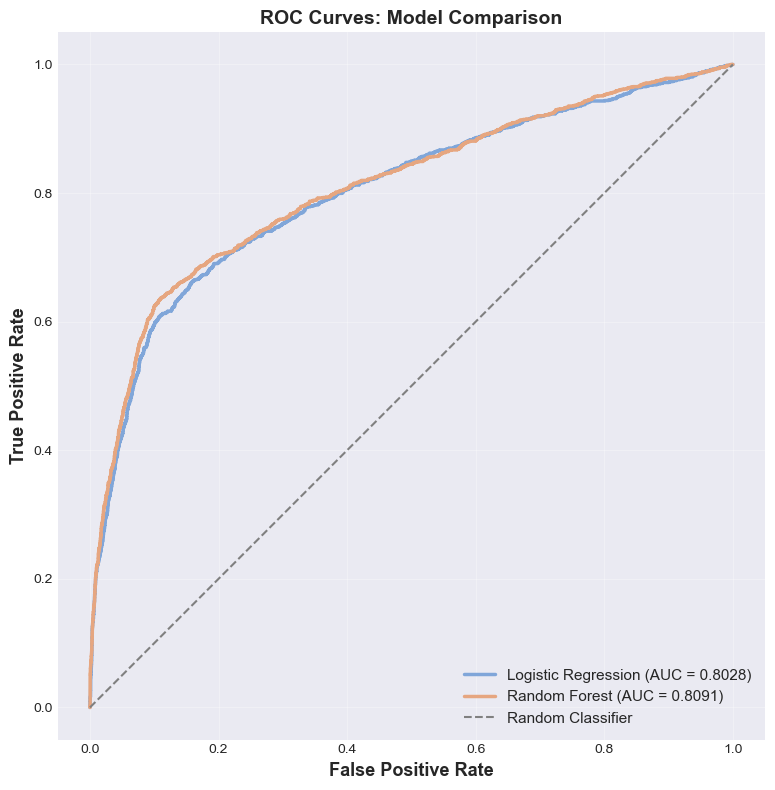

In [16]:
# Cell 14: Figure 5 - ROC Curves
"""
Figure 5: ROC Curves Comparison
"""

print("\n" + "="*60)
print("VISUALIZATIONS - MODEL COMPARISON")
print("="*60)

print("\nFigure 5: ROC Curves...")

# Calculate ROC curves
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_test_prob_lr)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_test_prob_rf)

# Plot
fig, ax = plt.subplots(figsize=(10, 8))

ax.plot(fpr_lr, tpr_lr, linewidth=2.5, color=color_lr, 
        label=f'Logistic Regression (AUC = {auc_lr:.4f})')
ax.plot(fpr_rf, tpr_rf, linewidth=2.5, color=color_rf, 
        label=f'Random Forest (AUC = {auc_rf:.4f})')
ax.plot([0, 1], [0, 1], '--', linewidth=1.5, color='gray', 
        label='Random Classifier')

ax.set_xlabel('False Positive Rate', fontsize=13, weight='bold')
ax.set_ylabel('True Positive Rate', fontsize=13, weight='bold')
ax.set_title('ROC Curves: Model Comparison', fontsize=14, weight='bold')
ax.legend(fontsize=11, loc='lower right')
ax.grid(True, alpha=0.3)
ax.set_aspect('equal')

plt.tight_layout()
plt.show()


Figure 6: Precision-Recall Curves...


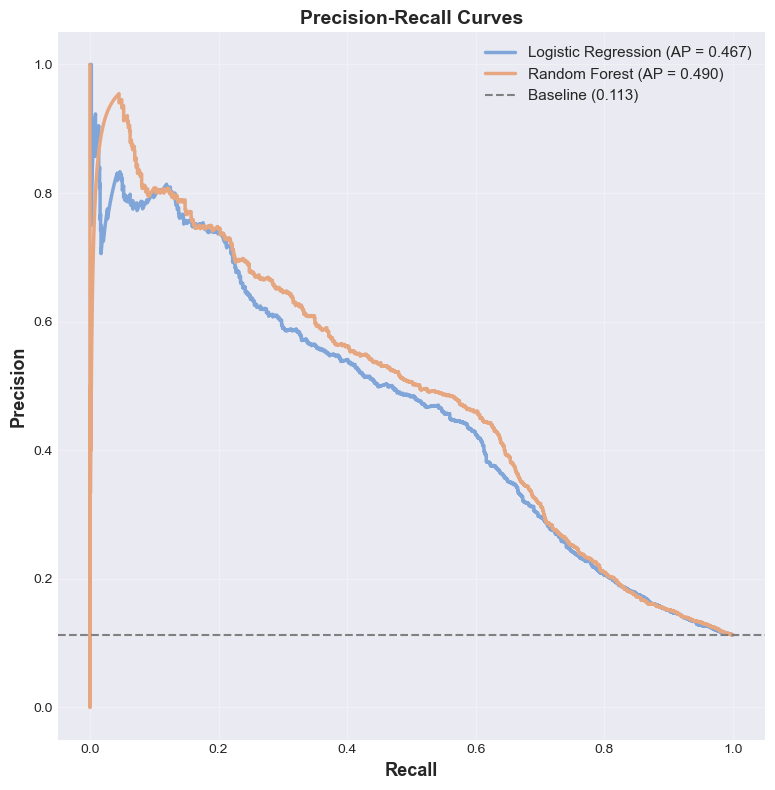

In [17]:
# Cell 15: Figure 6 - Precision-Recall Curves
"""
Figure 6: Precision-Recall Curves
"""

print("\nFigure 6: Precision-Recall Curves...")

# Calculate PR curves
prec_curve_lr, rec_curve_lr, _ = precision_recall_curve(y_test, y_test_prob_lr)
prec_curve_rf, rec_curve_rf, _ = precision_recall_curve(y_test, y_test_prob_rf)

# Calculate average precision
from sklearn.metrics import average_precision_score
ap_lr = average_precision_score(y_test, y_test_prob_lr)
ap_rf = average_precision_score(y_test, y_test_prob_rf)

# Plot
fig, ax = plt.subplots(figsize=(10, 8))

ax.plot(rec_curve_lr, prec_curve_lr, linewidth=2.5, color=color_lr, 
        label=f'Logistic Regression (AP = {ap_lr:.3f})')
ax.plot(rec_curve_rf, prec_curve_rf, linewidth=2.5, color=color_rf, 
        label=f'Random Forest (AP = {ap_rf:.3f})')
ax.axhline(y=y_test.mean(), linestyle='--', linewidth=1.5, color='gray', 
           label=f'Baseline ({y_test.mean():.3f})')

ax.set_xlabel('Recall', fontsize=13, weight='bold')
ax.set_ylabel('Precision', fontsize=13, weight='bold')
ax.set_title('Precision-Recall Curves', fontsize=14, weight='bold')
ax.legend(fontsize=11, loc='upper right')
ax.grid(True, alpha=0.3)
ax.set_aspect('equal')

plt.tight_layout()
plt.show()


Figure 7: Confusion Matrix - Logistic Regression...


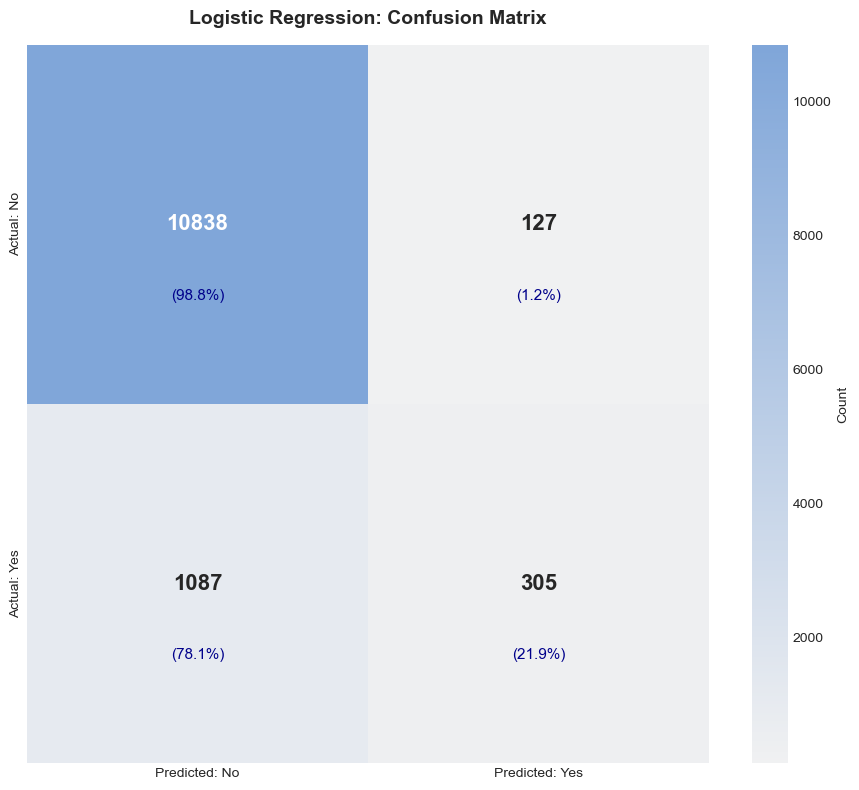

In [18]:
# Cell 16: Figure 7 - Confusion Matrix (Logistic Regression)
"""
Figure 7: Confusion Matrix - Logistic Regression
"""

print("\nFigure 7: Confusion Matrix - Logistic Regression...")

fig, ax = plt.subplots(figsize=(9, 8))

# Create custom colormap
cmap = sns.light_palette(color_lr, as_cmap=True)

# Plot
sns.heatmap(cm_lr, annot=True, fmt='d', cmap=cmap, 
            cbar_kws={'label': 'Count'},
            xticklabels=['Predicted: No', 'Predicted: Yes'],
            yticklabels=['Actual: No', 'Actual: Yes'],
            ax=ax, annot_kws={'fontsize': 16, 'weight': 'bold'})

ax.set_title('Logistic Regression: Confusion Matrix', 
             fontsize=14, weight='bold', pad=15)

# Add percentages
for i in range(2):
    for j in range(2):
        pct = 100 * cm_lr[i, j] / cm_lr[i, :].sum()
        ax.text(j+0.5, i+0.7, f'({pct:.1f}%)', 
               ha='center', va='center', fontsize=11, color='darkblue')

plt.tight_layout()
plt.show()


Figure 8: Confusion Matrix - Random Forest...


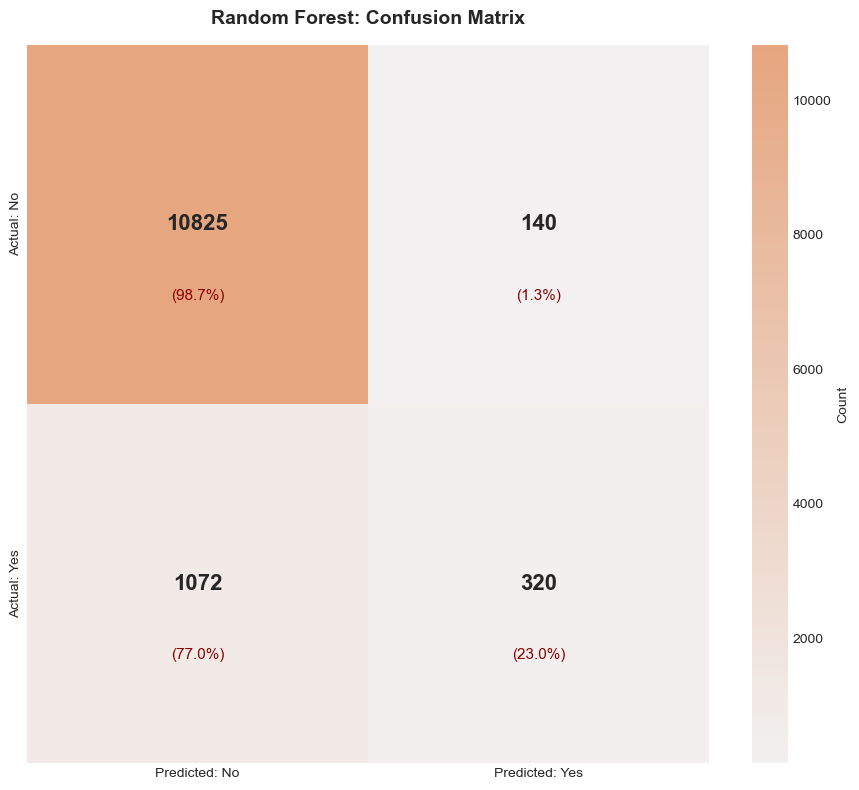

In [19]:
# Cell 17: Figure 8 - Confusion Matrix (Random Forest)
"""
Figure 8: Confusion Matrix - Random Forest
"""

print("\nFigure 8: Confusion Matrix - Random Forest...")

fig, ax = plt.subplots(figsize=(9, 8))

# Create custom colormap
cmap = sns.light_palette(color_rf, as_cmap=True)

# Plot
sns.heatmap(cm_rf, annot=True, fmt='d', cmap=cmap, 
            cbar_kws={'label': 'Count'},
            xticklabels=['Predicted: No', 'Predicted: Yes'],
            yticklabels=['Actual: No', 'Actual: Yes'],
            ax=ax, annot_kws={'fontsize': 16, 'weight': 'bold'})

ax.set_title('Random Forest: Confusion Matrix', 
             fontsize=14, weight='bold', pad=15)

# Add percentages
for i in range(2):
    for j in range(2):
        pct = 100 * cm_rf[i, j] / cm_rf[i, :].sum()
        ax.text(j+0.5, i+0.7, f'({pct:.1f}%)', 
               ha='center', va='center', fontsize=11, color='darkred')

plt.tight_layout()
plt.show()